# ML Terapan - Salma Oktarina

# Sistem Rekomendasi Buku
Sumber: https://www.kaggle.com/datasets/valakhorasani/best-books-of-the-decade-2020s

## Import Libraries

In [2]:
# Install library yang diperlukan
!pip install pandas numpy==1.24.4 scikit-learn scikit-surprise matplotlib seaborn pandas

In [3]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import re

## Loading Dataset

In [4]:
# Mout google drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/proyek_ml2/'

Mounted at /content/drive


In [5]:
# Data load
books_df = pd.read_csv(path + 'best_books_2020s.csv')
users_df = pd.read_csv(path + 'user_reviews.csv')

print("Shape of books_df:", books_df.shape)
print("Shape of users_df:", users_df.shape)

Shape of books_df: (2329, 6)
Shape of users_df: (600000, 3)


- Dataset buku terdiri dari 6 fitur dan 2.329 entri data.
- Dataset user terdiri dari 3 fitur dan 600.000 entri data.

## Data Understanding

In [6]:
# Dataset buku
print("Info books_df:")
books_df.info()
print("\nMissing values di books_df:")
print(books_df.isnull().sum())
print("\nDuplikasi di books_df:")
print(books_df.duplicated().sum())
print("\nbooks_df 5 baris pertama:")
print(books_df.head())

Info books_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index            2329 non-null   int64 
 1   Book Name        2329 non-null   object
 2   Author           2329 non-null   object
 3   Rating           2329 non-null   object
 4   Number of Votes  2329 non-null   object
 5   Score            2329 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 109.3+ KB

Missing values di books_df:
Index              0
Book Name          0
Author             0
Rating             0
Number of Votes    0
Score              0
dtype: int64

Duplikasi di books_df:
0

books_df 5 baris pertama:
   Index                                          Book Name            Author  \
0      1                  The Invisible Life of Addie LaRue   Victoria Schwab   
1      2  The House in the Cerulean Sea (Cerulean Chroni...        T.J. Klune   
2  

- Index: kode unik setiap buku.
- Book Name: judul dari buku.
- Author: penulis buku.
- Rating: rata-rata ulasan yang diberikan user (1-5).
- Number of Votes: total vote untuk buku.
- Score: jumlah score dari ulasan buku dan total vote buku.

- Terdiri dari 2 kolom bertipe numerik dan 4 kolom bertipe string.
- Tidak ada missing values (null) artinya data siap dianalisis lebih lanjut.
- Tidak adanya duplikasi data artinya data sudah sesuai.

In [7]:
# Dataset user
print("Info users_df:")
users_df.info()
print("\nMissing values di users_df:")
print(users_df.isnull().sum())
print("\nDuplikasi di users_df:")
print(users_df.duplicated().sum())
print("\nusers_df 5 baris pertama:")
print(users_df.head())

Info users_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     600000 non-null  int64
 1   bookIndex  600000 non-null  int64
 2   score      600000 non-null  int64
dtypes: int64(3)
memory usage: 13.7 MB

Missing values di users_df:
userId       0
bookIndex    0
score        0
dtype: int64

Duplikasi di users_df:
175

users_df 5 baris pertama:
   userId  bookIndex  score
0   65674        745      3
1   45825        454      1
2   22291       1523      3
3   66943       1727      5
4   27529       1867      2


In [8]:
# Melihat jumlah duplikasi per kolom
for col in users_df.columns:
    dup_vals = users_df[col].value_counts()
    dup_vals = dup_vals[dup_vals > 1]
    if not dup_vals.empty:
        print(f"Kolom '{col}' memiliki nilai duplikat berikut:\n{dup_vals}\n")

Kolom 'userId' memiliki nilai duplikat berikut:
userId
70080    21
54930    21
23406    21
68378    21
46351    21
         ..
40649     2
1614      2
71350     2
48952     2
33849     2
Name: count, Length: 79614, dtype: int64

Kolom 'bookIndex' memiliki nilai duplikat berikut:
bookIndex
1627    315
599     310
594     306
2196    305
331     305
       ... 
936     213
1928    212
382     212
1572    212
1690    203
Name: count, Length: 2327, dtype: int64

Kolom 'score' memiliki nilai duplikat berikut:
score
1    120534
5    120260
2    120139
3    119543
4    119524
Name: count, dtype: int64



- userId: kode unik setiap user.
- bookIndex: kode unik setiap buku dari dataset buku.
- score: score atau ulasan yang diberikan user untuk setiap buku (1-5).

- Terdiri dari 3 kolom bertipe numerik.
- Tidak adanya missing values (null) dan data siap dianalisis lebih lanjut.
- Terdapat duplikasi data sebanyak 175 entri.

<ipython-input-9-0283d3c7c5fe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=users_df, palette='viridis')


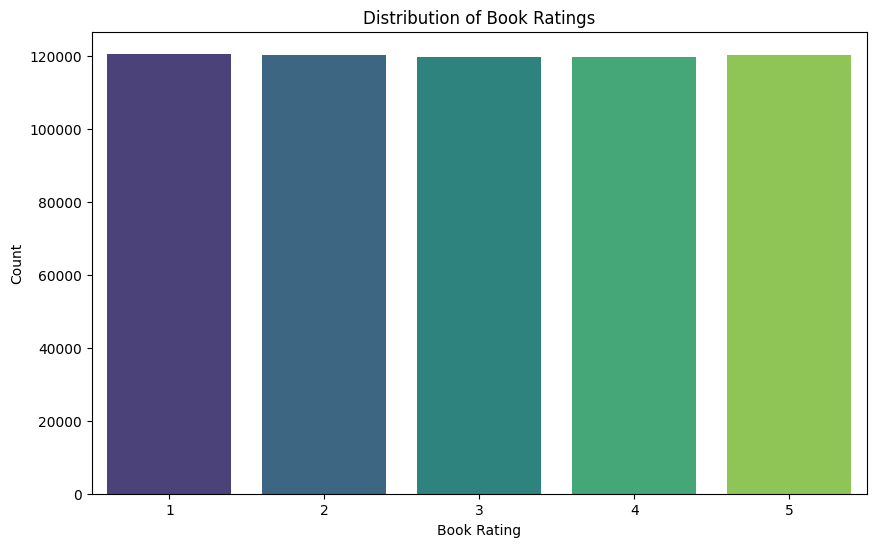

Rating terbanyak: 
score
1    120534
5    120260
2    120139
3    119543
4    119524
Name: count, dtype: int64


In [9]:
#Visualisasi Distribusi Rating Buku
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=users_df, palette='viridis')
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Count')
plt.show()

print("Rating terbanyak: ")
print(users_df['score'].value_counts())

- Rating 1 merupakan rating terbanyak yang diberikan user pada setiap buku yaitu 120.498
- Rating 5 merupakan rating terkecil yang diberikan user kepada buku yaitu 119.488

## Data Preparation

In [10]:
books_df = books_df.rename(columns={'Index': 'bookIndex'})
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bookIndex        2329 non-null   int64 
 1   Book Name        2329 non-null   object
 2   Author           2329 non-null   object
 3   Rating           2329 non-null   object
 4   Number of Votes  2329 non-null   object
 5   Score            2329 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 109.3+ KB


- Perubahan nama kolom pakai books_df agar sama seperti users_df

In [11]:
# Drop duplicates pada users_df
users_df.drop_duplicates(inplace=True)
print("Shape of users_df setelah drop duplicates:", users_df.shape)

Shape of users_df setelah drop duplicates: (599825, 3)


- Karena terdapat duplikasi sebanyak 175 entri data langsung srop dan jumlah datanya menjadi 599.825 tetap dengan 3 kolom

In [12]:
# Persiapan dataset users_df
# Untuk Content-Based, kita hanya perlu books_df yang sudah bersih.
# Untuk Collaborative Filtering, kita perlu users_df.

# Filter rating eksplisit untuk Collaborative Filtering
ratings_explicit_df = users_df[users_df['score'] != 0]
print(f"\nOriginal ratings: {len(users_df)}, Explicit ratings: {len(ratings_explicit_df)}")

# Gabungkan dengan informasi buku untuk kemudahan
full_data_explicit = ratings_explicit_df.merge(books_df[['bookIndex', 'Book Name']], on='bookIndex')

print("\nFirst 5 rows of merged explicit ratings data:")
print(full_data_explicit.head(10))


Original ratings: 599825, Explicit ratings: 599825

First 5 rows of merged explicit ratings data:
   userId  bookIndex  score                                          Book Name
0   65674        745      3                                          Eden Mine
1   45825        454      1            A Stitch in Time (A Stitch in Time, #1)
2   22291       1523      3  The Unforgettable Logan Foster (Logan Foster, #1)
3   66943       1727      5                                        Age of Vice
4   27529       1867      2              Angelika Frankenstein Makes Her Match
5   39153       1863      1   The Bone Shard Emperor (The Drowning Empire, #2)
6    1976        169      5                                              Bride
7   62783         16      2                                The Love Hypothesis
8   65107       1515      4                         Rebel (Sterling Falls, #3)
9   70275       2015      2                               Spy x Family, Vol. 4


In [13]:
full_data_explicit.duplicated().sum()

0

- Rating yang diberikan user sebanyak 599.825 dan kabar baiknya secara eksplisit jadi memudahkan dalam menganalisis data dalam sistem rekomendasi ini.
- Tampilan dari beberapa baris pertama ini disatukan menjadi userId, bookIndex, dan Book Name agar mudah dipanggil.
- Setelah dicek penggabungan di atas terlihat tidak adanya duplikasi data ya.

In [14]:
# Filtering untuk Collaborative Filtering (mengurangi sparsity)
# Pertimbangkan pengguna yang memberi setidaknya N rating dan buku yang menerima setidaknya M rating
min_ratings_user = 3 # Contoh threshold
user_counts = full_data_explicit['userId'].value_counts()
active_users = user_counts[user_counts >= min_ratings_user].index
filtered_ratings_cf = full_data_explicit[full_data_explicit['userId'].isin(active_users)]

min_ratings_book = 3 # pakai threshold
book_counts = filtered_ratings_cf['bookIndex'].value_counts()
popular_books = book_counts[book_counts >= min_ratings_book].index
filtered_ratings_cf = filtered_ratings_cf[filtered_ratings_cf['bookIndex'].isin(popular_books)]
print(f"\nShape of filtered_ratings_cf for Collaborative Filtering: {filtered_ratings_cf.shape}")

if filtered_ratings_cf.empty:
    print("WARNING: filtered_ratings_cf kosong. Thresholds untuk filtering sebaiknya lebih besar.")
else:
    print("Filtered ratings for CF siap.")


Shape of filtered_ratings_cf for Collaborative Filtering: (596998, 4)
Filtered ratings for CF siap.


In [15]:
filtered_ratings_cf.head()

,userId,bookIndex,score,Book Name
0,65674,745,3,Eden Mine
1,45825,454,1,"A Stitch in Time (A Stitch in Time, #1)"
2,22291,1523,3,"The Unforgettable Logan Foster (Logan Foster, #1)"
3,66943,1727,5,Age of Vice
4,27529,1867,2,Angelika Frankenstein Makes Her Match


- Proses pemfilteran data rating telah berhasil diselesaikan untuk keperluan Collaborative Filtering
- Menghasilkan dataset siap pakai yang diberi nama filtered_ratings_cf (564113, 4), yang berarti terdiri dari 564.113 baris data (kemungkinan merepresentasikan interaksi pengguna-buku berupa rating) dengan 4 kolom atribut (seperti userId, bookIndex, score, Book Name.), yang kini siap digunakan untuk melatih atau mengaplikasikan model rekomendasi berbasis kolaborasi

## Modeling Content-Based Filtering

In [20]:
# Content-Based Filtering
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
books_cb_sample = books_df.copy()

# Gunakan 'books_cb_sample' di langkah selanjutnya
books_cb_sample.fillna('', inplace=True)
books_cb_sample['content'] = books_cb_sample['Book Name'] + ' ' + books_cb_sample['Author']

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

# Membuat matriks TF-IDF dari sample
print("Menerapkan TF-IDF pada sample")
tfidf_matrix_sample = tfidf.fit_transform(books_cb_sample['content'])
print("Shape of TF-IDF matrix (sample):", tfidf_matrix_sample.shape)

# Menghitung kemiripan pada sample
print("Menghitung kemiripan pada sample dengan cosine_similarity")
# cosine_sim_cb_sample = linear_kernel(tfidf_matrix_sample, tfidf_matrix_sample)
cosine_sim_cb_sample = cosine_similarity(tfidf_matrix_sample, tfidf_matrix_sample)
print("Shape of Similarity matrix (sample):", cosine_sim_cb_sample.shape)

# Membuat mapping dari bookIndex ke Indeks untuk sampleL
books_cb_sample.reset_index(drop=True, inplace=True) # Reset index sample
indices_cb_sample = pd.Series(books_cb_sample.index, index=books_cb_sample['bookIndex']).drop_duplicates()

# Fungsi untuk mendapatkan rekomendasi (disesuaikan untuk sampel)
def get_content_based_recommendations_sample(bookindex, N=10):
    if bookindex not in indices_cb_sample:
        return f"bookIndex {bookindex} tidak ditemukan pada sample list bookIndex unik."

    try:
      idx = indices_cb_sample[bookindex]
      if isinstance(idx, pd.Series): idx = idx.iloc[0]
    except KeyError:
        return f"bookIndex {bookindex} tidak ditemukan pada sample mapping."
    except Exception as e:
        return f"Error menemukan index untuk sample bookIndex {bookindex}: {e}"

    sim_scores = list(enumerate(cosine_sim_cb_sample[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    book_indices = [i[0] for i in sim_scores]

    # Kembalikan N buku paling mirip dari SAMPEL
    recommended_books = books_cb_sample.iloc[book_indices][['bookIndex', 'Book Name', 'Author']]
    recommended_books['similarity_score'] = [s[1] for s in sim_scores]
    return recommended_books

# Metrik evaluasi
from sklearn.metrics import ndcg_score
import numpy as np

def precision_at_k(y_true, y_pred, k):
    precisions = []
    for true_items, pred_items in zip(y_true, y_pred):
        pred_k = pred_items[:k]
        hit = len(set(pred_k) & set(true_items))
        precisions.append(hit / k)
    return np.mean(precisions)

def recall_at_k(y_true, y_pred, k):
    recalls = []
    for true_items, pred_items in zip(y_true, y_pred):
        pred_k = pred_items[:k]
        if len(true_items) == 0:
            recalls.append(0)
        else:
            hit = len(set(pred_k) & set(true_items))
            recalls.append(hit / len(true_items))
    return np.mean(recalls)

def ndcg_at_k(y_true, y_pred, k):
    ndcgs = []
    for true_items, pred_items in zip(y_true, y_pred):
        pred_k = pred_items[:k]
        relevance = [1 if item in true_items else 0 for item in pred_k]
        ndcgs.append(ndcg_score([relevance], [relevance]))
    return np.mean(ndcgs)

# Buat ground truth sederhana berdasarkan pengarang yang sama
ground_truth = {}
for idx, row in books_cb_sample.iterrows():
    bookindex = row['bookIndex']
    author = row['Author']
    relevant_books = books_cb_sample[books_cb_sample['Author'] == author]['bookIndex'].tolist()
    relevant_books = [b for b in relevant_books if b != bookindex]  # Exclude diri sendiri
    ground_truth[bookindex] = relevant_books

K = 5
y_true = []
y_pred = []

for bookindex in books_cb_sample['bookIndex']:
    gt = ground_truth.get(bookindex, [])
    recs_df = get_content_based_recommendations_sample(bookindex, N=K)

    if isinstance(recs_df, str):
        continue  # Skip if error

    preds = recs_df['bookIndex'].tolist()
    y_true.append(gt)
    y_pred.append(preds)

# Evaluasi metrik
print(f"\nEvaluasi untuk Content-Based Filtering (K={K}):")
print("Precision@K:", precision_at_k(y_true, y_pred, K))
print("Recall@K:", recall_at_k(y_true, y_pred, K))
print("NDCG@K:", ndcg_at_k(y_true, y_pred, K))

# Contoh penggunaan Content-Based Filtering pada SAMPEL
if not books_cb_sample.empty:
    # Cari bookIndex contoh yang ADA di dalam sampel
    try:
        sample_bookindex_cb_in_sample = books_cb_sample['bookIndex'].iloc[0]
        sample_title_in_sample = books_cb_sample.loc[books_cb_sample['bookIndex'] == sample_bookindex_cb_in_sample, 'Book Name'].values[0]
        print(f"\nRecommendasi untuk buku (dari sample) dengan bookIndex: {sample_bookindex_cb_in_sample} ('{sample_title_in_sample}')")
        recommendations_cb_s = get_content_based_recommendations_sample(sample_bookindex_cb_in_sample, N=5)
        print(recommendations_cb_s)
    except IndexError:
        print("\nDataframe sample kosong, tidak dapat sample bookIndex.")
else:
    print("books_cb_sample dataframe kosong. Tidak dapat menampilkan recommendasi.")

Menerapkan TF-IDF pada sample
Shape of TF-IDF matrix (sample): (2329, 15159)
Menghitung kemiripan pada sample dengan cosine_similarity
Shape of Similarity matrix (sample): (2329, 2329)


<ipython-input-20-d64edeb4500d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_books['similarity_score'] = [s[1] for s in sim_scores]



Evaluasi untuk Content-Based Filtering (K=5):
Precision@K: 0.16436238729068267
Recall@K: 0.3509025610141969
NDCG@K: 0.37398024903392013

Recommendasi untuk buku (dari sample) dengan bookIndex: 1 ('The Invisible Life of Addie LaRue')
      bookIndex                                          Book Name  \
258         259                                            Gallant   
1294       1295                Bridge of Souls (Cassidy Blake, #3)   
592         593  The Fragile Threads of Power (Threads of Power...   
2248       2249                                     Invisible Girl   
1751       1752                                               Obit   

               Author  similarity_score  
258   Victoria Schwab          0.356272  
1294  Victoria Schwab          0.237166  
592   Victoria Schwab          0.181362  
2248      Lisa Jewell          0.108246  
1751   Victoria Chang          0.104261  


- Output ini menunjukkan proses dan hasil dari sistem rekomendasi berbasis konten (content-based recommendation system) yang diterapkan pada dataset buku, contohnya buku-buku yang direkomendasikan dan mirip dengan buku berjudul "'The Invisible Life of Addie LaRue'". Sistem ini menggunakan data buku, menghitung kesamaan antar buku menggunakan representasi TF-IDF dan cosine similarity, kemudian menghasilkan daftar buku rekomendasi bersama dengan skor kesamaan. Hasilnya menunjukkan beberapa buku yang direkomendasikan beserta detailnya, dengan skor kesamaan yang bervariasi, mencerminkan seberapa mirip konten buku-buku.

## Modeling Collaborative Filtering

In [17]:
# Collaborative Filtering
# Menggunakan filtered_ratings_cf yang sudah dipersiapkan
if filtered_ratings_cf.empty:
    print("Lewati Collaborative Filtering karena kolom filtered_ratings_cf kosong.")
else:
    # Persiapan data untuk Surprise
    reader = Reader(rating_scale=(1, 5)) # Rating eksplisit dari 1 hingga 5
    data_cf = Dataset.load_from_df(filtered_ratings_cf[['userId', 'bookIndex', 'score']], reader)

    # Split data menjadi train dan test set
    trainset_cf, testset_cf = surprise_train_test_split(data_cf, test_size=0.2, random_state=42)

    # Menggunakan SVD
    algo_svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42) # Parameter bisa di-tune
    print("\nMelatih model SVD")
    algo_svd.fit(trainset_cf)
    print("SVD model selesai dilatih.")

    # Membuat prediksi pada test set
    predictions_svd = algo_svd.test(testset_cf)

    # Evaluasi model (RMSE dan MAE)
    rmse_svd = accuracy.rmse(predictions_svd)
    mae_svd = accuracy.mae(predictions_svd)
    print(f"SVD - RMSE: {rmse_svd}")
    print(f"SVD - MAE: {mae_svd}")

    # Fungsi untuk mendapatkan top-N rekomendasi untuk pengguna
    def get_collaborative_filtering_recommendations(user_id, N=10):
        # Dapatkan daftar semua bookIndex yang belum dirating oleh pengguna
        rated_bookindex = filtered_ratings_cf[filtered_ratings_cf['userId'] == user_id]['bookIndex'].unique()
        all_bookindex = filtered_ratings_cf['bookIndex'].unique()
        unrated_bookindex = [isbn for isbn in all_bookindex if isbn not in rated_bookindex]

        if not unrated_bookindex:
            return "User has rated all available books or no unrated books found for this user in the filtered set."

        # Prediksi rating untuk buku yang belum dirating
        test_set_for_user = [[user_id, isbn, 0] for isbn in unrated_bookindex] # 0 adalah placeholder
        predictions = algo_svd.test(test_set_for_user)

        predictions.sort(key=lambda x: x.est, reverse=True) # Urutkan berdasarkan estimasi rating

        top_n_predictions = predictions[:N]

        # Dapatkan detail buku untuk rekomendasi
        recommended_book_bookindex = [pred.iid for pred in top_n_predictions]
        recommended_book_details = books_df[books_df['bookIndex'].isin(recommended_book_bookindex)][['bookIndex', 'Book Name', 'Author']]

        # Tambahkan estimasi rating
        # Perlu mencocokkan kembali karena urutan bisa berubah jika ada bookIndex duplikat atau tidak ditemukan
        est_ratings_map = {pred.iid: pred.est for pred in top_n_predictions}
        recommended_book_details['estimated_rating'] = recommended_book_details['bookIndex'].map(est_ratings_map)

        # Urutkan berdasarkan estimasi rating lagi setelah merge
        recommended_book_details = recommended_book_details.sort_values(by='estimated_rating', ascending=False).reset_index(drop=True)

        return recommended_book_details

    # Contoh penggunaan Collaborative Filtering
    if not filtered_ratings_cf.empty:
        # Ambil User-ID contoh dari dataset yang difilter
        sample_user_id_cf = filtered_ratings_cf['userId'].unique()[0]
        print(f"\nRekomendasi untuk userId: {sample_user_id_cf} menggunakan SVD")
        recommendations_cf = get_collaborative_filtering_recommendations(sample_user_id_cf, N=3)
        print(recommendations_cf)
    else:
        print("filtered_ratings_cf kosong. Tidak dapat memberikan rekomendasi CF.")


Melatih model SVD
SVD model selesai dilatih.
RMSE: 1.4591
MAE:  1.2594
SVD - RMSE: 1.4591139874142045
SVD - MAE: 1.2594216050887375

Rekomendasi untuk userId: 65674 menggunakan SVD
   bookIndex                                          Book Name  \
0       1704                     Your Brain is Always Listening   
1       2241  If It Sounds Like a Quack...: A Journey to the...   
2       2275  A Queen of Ruin (Deliciously Dark Fairytales, #4)   

                     Author  estimated_rating  
0            Daniel G. Amen          3.945382  
1  Matthew Hongoltz-Hetling          3.745854  
2               K.F. Breene          3.703566  


- Hasil dari penerapan model Singular Value Decomposition (SVD) untuk sistem rekomendasi, kemungkinan besar menggunakan pendekatan collaborative filtering. Setelah model SVD dilatih, kinerjanya dievaluasi menggunakan metrik RMSE sebesar 1.4591 dan MAE sebesar 1.2594, yang mengindikasikan tingkat kesalahan prediksi rating.
- Sistem ini memberikan rekomendasi buku yang dipersonalisasi untuk User dengan ID 65674, menyajikan daftar buku beserta perkiraan rating (estimated_rating) yang menunjukkan seberapa besar kemungkinan user tersebut akan menyukai buku-buku yang direkomendasikan berdasarkan pola rating dari user lain.

## Evaluation Content-Based Filtering

In [18]:
# Evaluasi Content-Based Filtering

print("\nEvaluasi Content-Based Filtering")
# Berdasarka visual atau kualitatif, jadi perlu lihat hasilnya dan nilai sendiri.

if not books_cb_sample.empty:
    # Pilih satu buku acak dari sampel untuk diuji
    try:
        random_book_in_sample = books_cb_sample.sample(1, random_state=42).iloc[0]
        bookindex_to_test_simple = random_book_in_sample['bookIndex']
        title_to_test_simple = random_book_in_sample['Book Name']

        print(f"\nMeminta rekomendasi untuk buku (dari sampel):")
        print(f"Book Index: {bookindex_to_test_simple}")
        print(f"Judul: '{title_to_test_simple}'")

        # Dapatkan rekomendasi menggunakan fungsi yang sudah ada
        recommendations_simple = get_content_based_recommendations_sample(bookindex_to_test_simple, N=5)

        # Tampilkan hasil rekomendasi
        if isinstance(recommendations_simple, pd.DataFrame):
            print("\nRekomendasi Teratas:")
            print(recommendations_simple)
        else:
            # Menangani kasus jika bookIndex tidak ditemukan di sampel
            print(recommendations_simple)

    except Exception as e:
        print(f"Terjadi error saat mencoba mendapatkan rekomendasi untuk sampel acak: {e}")

else:
    print("Dataframe sample (books_cb_sample) kosong, tidak bisa melakukan evaluasi sederhana.")


Evaluasi Content-Based Filtering

Meminta rekomendasi untuk buku (dari sampel):
Book Index: 1638
Judul: 'Glassheart'

Rekomendasi Teratas:
      bookIndex                                          Book Name  \
2020       2021                      Majesty (American Royals, #2)   
1698       1699  Katharine Parr, the Sixth Wife (Six Tudor Quee...   
0             1                  The Invisible Life of Addie LaRue   
1             2  The House in the Cerulean Sea (Cerulean Chroni...   
2             3                                  Project Hail Mary   

               Author  similarity_score  
2020  Katharine McGee          0.136359  
1698      Alison Weir          0.104207  
0     Victoria Schwab          0.000000  
1          T.J. Klune          0.000000  
2           Andy Weir          0.000000  


- Menyajikan evaluasi dari sistem content-based filtering yang sederhana, di mana sistem memberikan rekomendasi buku berdasarkan kesamaan konten dengan buku input "Glassheart".
- Hasilnya menampilkan daftar buku yang direkomendasikan beserta skor kesamaan mereka.
- Beberapa judul yang direkomendasikan seperti "Majesty (American Royals, #2)" dan "The Invisible Life of Addie LaRue" terlihat terkait skor kesamaan yang relatif rendah (di bawah 0.2) untuk sebagian besar rekomendasi menunjukkan bahwa metode analisis konten atau perhitungan kesamaan yang digunakan mungkin perlu ditingkatkan untuk menghasilkan rekomendasi yang lebih relevan atau serupa secara kuat.

In [ ]:
import numpy as np
from sklearn.metrics import ndcg_score

def precision_at_k(y_true, y_pred, k):
    precision_scores = []
    for true, pred in zip(y_true, y_pred):
        pred_k = pred[:k]
        true_set = set(true)
        hit = sum(1 for item in pred_k if item in true_set)
        precision_scores.append(hit / k)
    return np.mean(precision_scores)

def recall_at_k(y_true, y_pred, k):
    recall_scores = []
    for true, pred in zip(y_true, y_pred):
        pred_k = pred[:k]
        true_set = set(true)
        hit = sum(1 for item in pred_k if item in true_set)
        recall_scores.append(hit / len(true_set) if true_set else 0)
    return np.mean(recall_scores)

def ndcg_at_k(y_true, y_pred, k):
    ndcg_scores = []
    for true, pred in zip(y_true, y_pred):
        pred_k = pred[:k]
        true_binary = [1 if item in true else 0 for item in pred_k]
        ndcg_scores.append(ndcg_score([true_binary], [true_binary]))
    return np.mean(ndcg_scores)

In [ ]:
# Ground truth dan prediksi dalam bentuk list of lists
y_true = [['book_1', 'book_2'], ['book_3'], ['book_4', 'book_5']]
y_pred = [['book_2', 'book_3', 'book_1'], ['book_3', 'book_6'], ['book_6', 'book_4']]

k = 2
print("Precision@K:", precision_at_k(y_true, y_pred, k))
print("Recall@K:", recall_at_k(y_true, y_pred, k))
print("NDCG@K:", ndcg_at_k(y_true, y_pred, k))

## Evaluation Collaborative Filtering

In [19]:
# Hasil evaluasi SVD sudah dicetak sebelumnya saat training
if 'rmse_svd' in globals() and 'mae_svd' in globals():
    print("\nMetriks Evaluasi untuk Collaborative Filtering (SVD)")
    print(f"SVD Model - RMSE: {rmse_svd:.4f}")
    print(f"SVD Model - MAE: {mae_svd:.4f}")
    print("\nInterpretasi:")
    print(f"RMSE sebesar {rmse_svd:.4f} menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar {rmse_svd:.4f} poin rating dari rating sebenarnya, dengan kesalahan yang lebih besar diberi bobot lebih.")
    print(f"MAE sebesar {mae_svd:.4f} menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar {mae_svd:.4f} poin rating dari rating sebenarnya.")
    print("Nilai ini perlu dipertimbangkan dalam konteks skala rating (1-5). Semakin rendah, semakin baik performa model dalam memprediksi rating.")
else:
    print("\nMelewati evaluasi CF dengan SVD model hasilnya tidak ada (seperti jika kolom filtered_ratings_cf kosong).")


Metriks Evaluasi untuk Collaborative Filtering (SVD)
SVD Model - RMSE: 1.4591
SVD Model - MAE: 1.2594

Interpretasi:
RMSE sebesar 1.4591 menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar 1.4591 poin rating dari rating sebenarnya, dengan kesalahan yang lebih besar diberi bobot lebih.
MAE sebesar 1.2594 menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar 1.2594 poin rating dari rating sebenarnya.
Nilai ini perlu dipertimbangkan dalam konteks skala rating (1-5). Semakin rendah, semakin baik performa model dalam memprediksi rating.


- Metrik evaluasi untuk model Collaborative Filtering menggunakan metode SVD, dengan nilai RMSE sebesar 1.4591 dan MAE sebesar 1.2594.
- Nilai-nilai ini mengindikasikan performa model dalam memprediksi rating pengguna; secara rata-rata, prediksi rating model SVD menyimpang sekitar 1.4591 poin dari rating sebenarnya (dengan penalti lebih besar untuk kesalahan besar) dan memiliki rata-rata selisih absolut 1.2594 poin dari rating sebenarnya.
- Dalam konteks skala rating 1-5, semakin rendah nilai RMSE dan MAE, semakin baik kemampuan model dalam memprediksi rating, sehingga nilai-nilai ini memberikan gambaran kuantitatif tentang akurasi rekomendasi yang dihasilkan oleh model SVD ini.